# STAYSL Walk-through NIF
This example walks through the 
Passive 18x snout on TANDM 90-348 NIF Foil Activation Experiment performed by
Energetic Neutron Platform Working Group and NIF Radiochemistry Group

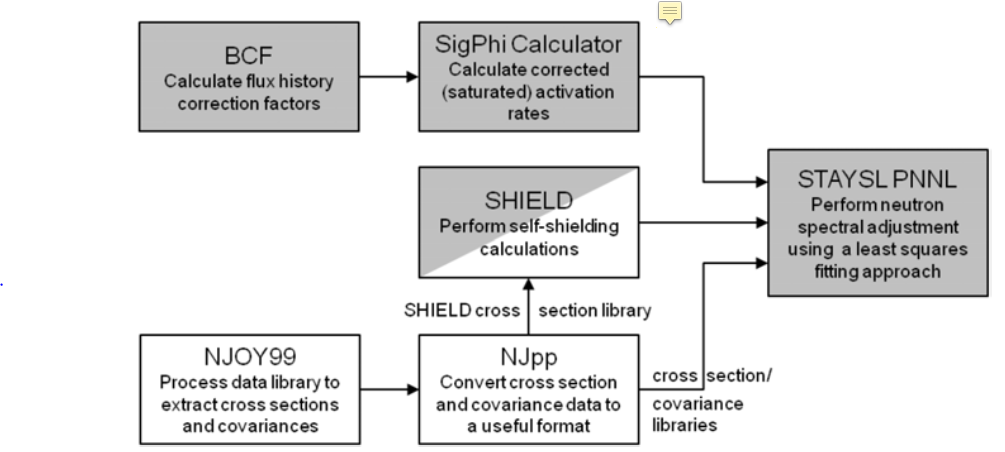
- This is from EPJWeb of Conferences 106, 07001 (2016) Least-Squares Neutron Spectral Adjustment with STAYSL PNNL L.R. Greenwooda and C.D. Johnson

# BCF - Beam Correction Factor
BCF corrects for irradiation history. The calculations performed correct for production and decay during the irradiation. At constant power or flux, this is a simple process 

$A_{0}=A_{\infty}*(1-exp(-\lambda*t))$

BCF normalizes the irradiation history to the time-weighted average reactor power or beam current. A correction factor is produced based on the irradiation hisotry for each isotope of interest. 

For the NIF, this module is not needed, BCF is not needef for a short irradiation time

## SHIELD
The SHIELD code calculates energy-dependent neutron self-shielding cross section correction factors that are used, prior to neutron spectral adjustment, to shield the neutron activation cross sections used by the STAYSL PNNL code. 

SHIELD was performed on ["shldinputNIF.dat"](https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/Unfold/SHIELD/shldinputNIF.dat). 

After a painstaking process of trial and error. It was determined that my executable of the SHIELD.exe can only be ran if: 
- Run command prompt as an administrator
- Use runExample batch file with filename replaced with desired input

I am unsure of why it requires this, I am guessing it is a permissions issue that I cannot work out. 

SHIELD is only necessary/valid on non-threshold reactions (n,gamma). SHIELD is dependent on the thickness of the material, so it must be re-ran if different foils/wires are used. 

An output file is created in the same directory shldinput.out

All foils are 1 mm (39.3701 mils) except for the Au foils, which are 0.1 mm

The output is renamed sshldlib.dat


## SigPhi Calculator

The [SigPhi Calculator](https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/Unfold/SIGPHI/SigPhi_Calculator_NIF.xlsm) was filled in with data from the [foil and activity information] (https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/ActivationData.xlsx)


The purpose of the SigPhi Calculator software is to calculate corrected saturated neutron activation rates from measured activities. These reaction rates, the so-called sig-phi values, represent the product of the spectral-averaged neutron activation cross section and the total neutron flux

The NIF is a very prompt output (~200 ps). There will be some downscatter which may slow a portion down. However, for the purposes of the irradiation, the irradiation time is taken as 1 second, and the reaction rates are taken as per second. This will not impact the results because the half-lives of the measured products are orders of magnitude different from this result. 

The export to excel did not work. Instead, the input was built-up using the calculated gamma shielding and At/At-s from the foil and activity information sheet

I couldn't get the SigPhi Calculator to work for me. I redownloaded everything and it gives me: 
￿￿￿￿￿￿￿￿￿￿ when I try to export to a STAYSL script. 

The sig-phi is calculated by dividing the number of nuclei created at t0 by the total number of atoms present in the foil. This is the relative production. 

The self-shielding factor for gammas is divided by this to correct for gamma self-shielding


# STAYSL

The STAYSL input deck was made with the SIG_PHI calculator and foil/activation data. 

The default values (From examples distributed with STAYSL) for Gaussian formalism were used. 

An iterative solution was performed on the input data and sets the uncertainty below 3 MeV to 100%. This was chosen because the model did not predict the down-scattering well. The baseline guess spectrum was developed using an Appelbe source split with a 14.03 MeV neutron peak at 10.75 keV temperature (See foil/activation Excel doc)

In [115]:
import sys
import os
sys.path.insert(0,os.path.abspath('C:/Users/nickq/Documents/AFIT_Masters/PyScripts/src'))


STAYSL is ran by executing the executable from the command line

# Pinhole Results

In [133]:
import pandas as pd
from DataAnalysis.DataManipulation import bin_integration, bin_differentiation

path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405v2/stayslin.out'
df = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df.apply(pd.to_numeric)

df['adjFlux'] = bin_integration(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low')
df['adjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low', True)
df['unadjFlux'] = bin_integration(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low')
df['unadjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low', True)

df['adjLethargyStd'] = df['adjStd'] * df['adjLethargy'] / 100
df['unadjLethargyStd'] = df['unadjStd'] * df['adjLethargy'] / 100
df['adjStd'] = df['adjStd'] * df['adjFlux'] / 100
df['unadjStd'] = df['unadjStd'] * df['unadjFlux'] / 100

df

,lowE,adjFlux,unadjFlux,fluxRatio,adjStd,unadjStd,uncertRatio,integralFlux,intFluxUncert,adjLethargy,unadjLethargy,adjLethargyStd,unadjLethargyStd
22,0.000045,2.882400e+07,9.913680e+07,0.291,3.130575e+07,1.300972e+08,0.828,4.006800e+12,5.19,6.743339e+07,2.319293e+08,7.323941e+07,8.849284e+07
23,0.000069,3.432010e+07,1.748648e+08,0.196,3.543550e+07,2.334445e+08,0.773,4.006800e+12,5.19,9.249113e+07,4.712528e+08,9.549709e+07,1.234757e+08
24,0.000100,3.541300e+07,1.982715e+08,0.179,3.404606e+07,2.685389e+08,0.710,4.006800e+12,5.19,1.180022e+08,6.606747e+08,1.134473e+08,1.598222e+08
25,0.000135,3.421355e+07,2.086000e+08,0.164,2.990949e+07,2.857611e+08,0.638,4.006700e+12,5.19,1.484167e+08,9.048963e+08,1.297458e+08,2.033160e+08
26,0.000170,4.145250e+07,2.719350e+08,0.152,3.217958e+07,3.764396e+08,0.561,4.006700e+12,5.19,1.607751e+08,1.054710e+09,1.248097e+08,2.225610e+08
27,0.000220,4.585860e+07,3.187500e+08,0.144,3.094538e+07,4.460269e+08,0.482,4.006600e+12,5.19,1.901568e+08,1.321725e+09,1.283178e+08,2.660864e+08
28,0.000280,5.245120e+07,3.786480e+08,0.139,3.041645e+07,5.354840e+08,0.410,4.006600e+12,5.19,2.087075e+08,1.506670e+09,1.210295e+08,2.951541e+08
29,0.000360,4.720590e+07,3.456000e+08,0.137,2.399948e+07,4.937242e+08,0.356,4.006500e+12,5.19,2.115495e+08,1.548779e+09,1.075518e+08,3.022196e+08
30,0.000450,5.739500e+07,4.151375e+08,0.138,2.764143e+07,5.990849e+08,0.334,4.006500e+12,5.19,2.341483e+08,1.693592e+09,1.127658e+08,3.378994e+08
31,0.000575,7.041470e+07,4.901760e+08,0.144,3.602416e+07,7.154119e+08,0.351,4.006400e+12,5.19,2.524291e+08,1.757228e+09,1.291427e+08,3.684203e+08


Plot first result

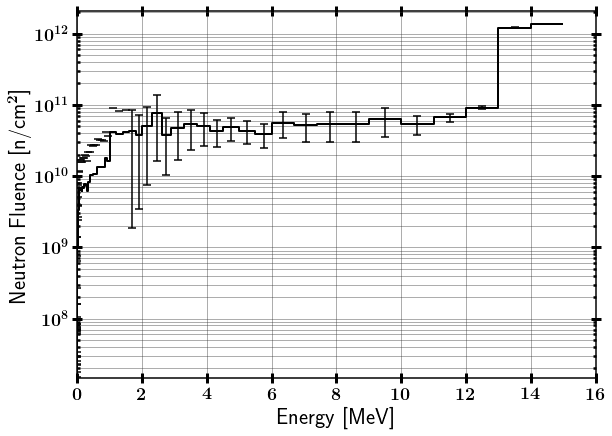

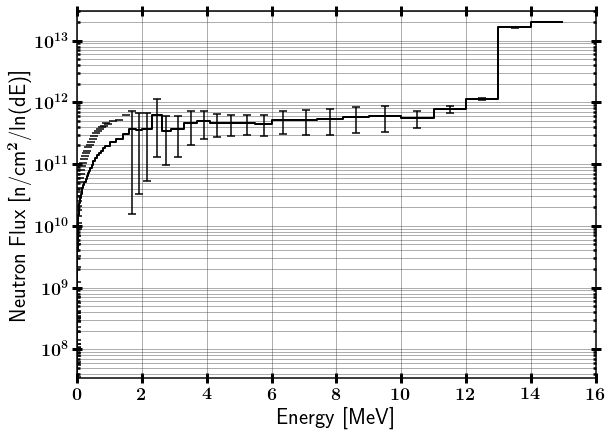

In [134]:
from DataAnalysis.Histograms import Histogram
import matplotlib
%matplotlib inline

outpath ='C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405v2/'
adjHisto = Histogram()
adjHisto.build_histo(df['lowE'].tolist(), df['adjFlux'].tolist(), uncert=df['adjStd'].tolist(),
                     edgeLoc='low')

adjHisto.plot(xMin=1E-6, logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                  savePath=outpath+'Pin1',includeMarkers=False,
                  legend=False)
adjLethargyHisto = Histogram()
adjLethargyHisto.build_histo(df['lowE'].tolist(), df['adjLethargy'].tolist(), uncert=df['adjLethargyStd'].tolist(),
                     edgeLoc='low')

adjLethargyHisto.plot( xMin=1E-6, logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Flux [n/cm$^2$/ln(dE)]',
                  savePath=outpath+'Pin1d_Lethargic',includeMarkers=False,
                  legend=False)

# Iterative Solution: Method 1
  - The iterative solution sets the uncertainty below 3 MeV to 100%.
  - It does not update the uncertainty until $\chi^2$ converged.

In [125]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=True, chiConv=0.1))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/
$\chi^2$ Convergence: 0.1
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: True
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/stayslin.out
Chi^2 = 26.55335, Std Norm = 10.7202823475
Chi^2 = 5793.01049
Chi^2 = 5690.5139
Chi^2 = 5695.09351
Chi^2 = 5693.80389
Chi^2 = 5694.71868
Chi^2 = 5694.0594
Chi^2 = 5694.55368
Chi^2 = 5694.19262
Chi^2 = 5694.47386
Chi^2 = 5694.26392
Chi^2 = 5694.42136
Chi^2 = 5694.30764
Chi^2 = 5694.39282
Std Norm = 13.5035357007, 13.5021836056


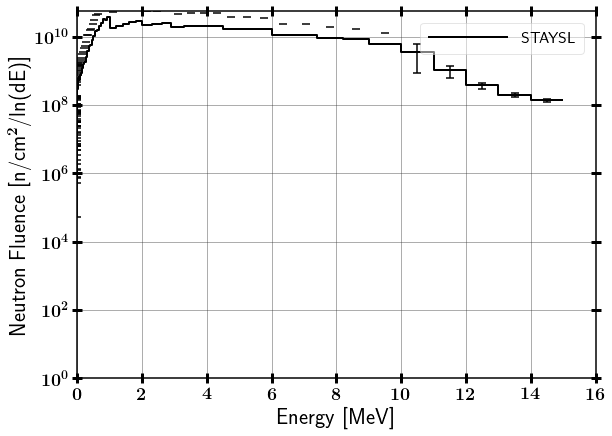

In [126]:
iter = 0

iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(),iterSoln[iter]._df['adjLethargy'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjLethargy']).tolist(),
                             edgeLoc='low', name='STAYSL')

iterAdjHisto[iter].plot(xMin=1E-6, xMax=16, yMin=1, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                        savePath=outpath+'PIN-Unfold_Itr{:1d}'.format(iter))


# Iterative Method 2:

  - The iterative solution sets the uncertainty below 3 MeV to 100%.
  - It does update the uncertainty throughout the convergence process.

In [131]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration2/'

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=True, chiConv=0.1))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())
iter = 1

iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(),iterSoln[iter]._df['adjLethargy'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjLethargy']).tolist(),
                             edgeLoc='low', name='STAYSL')

iterAdjHisto[iter].plot(xMin=1E-6, xMax=16, yMin=1, logX=False, logY=True, includeMarkers=False,
              xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                        savePath=outpath+'PIN-Unfold_Itr{:1d}'.format(iter))

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration2/
$\chi^2$ Convergence: 0.1
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: True
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration2/stayslin.out
Chi^2 = 18.86258, Std Norm = 4.74522173244
Chi^2 = 2410.17748
Chi^2 = 2317.53544
Chi^2 = 2315.61439
Chi^2 = 2323.37627
Chi^2 = 2307.5315
Chi^2 = 2325.81983
Chi^2 = 2302.30717
Chi^2 = 2328.10389
Chi^2 = 2296.46907
Chi^2 = 2329.88516
Chi^2 = 2296.08172
Chi^2 = 2330.85247
Chi^2 = 2296.65531
Chi^2 = 2330.47082
Chi^2 = 2296.39464
Chi^2 = 2330.69065
Chi^2 = 2296.63021
Chi^2 = 2330.52328
Chi^2 = 2296.51209
Chi^2 = 2330.63967
Chi^2 = 2296.59038
Chi^2 = 2330.56921
Chi^2 = 2296.55073
Chi^2 = 2330.60508
Chi^2 = 2296.56605
Chi^2 = 2330.58422
Chi^2 = 2296.55377
Chi^2 = 2330.59722
Chi^2 = 2296.55993
Chi^2 = 2330.58283
Chi^2 

KeyboardInterrupt: 

# Iterative Method 3:

  - No modifications are made to the MCNP results for the guess spectrum
  - It does update the uncertainty throughout the convergence process. 

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration3/
$\chi^2$ Convergence: 0.001
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: True
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration3/stayslin.out
Chi^2 = 2031.93357, Std Norm = 6.1175104863
Chi^2 = 1406.78344
Chi^2 = 5802.59208
Chi^2 = 5782.36836
Chi^2 = 5781.77363
Chi^2 = 5782.42254
Chi^2 = 5781.97387
Chi^2 = 5782.32234
Chi^2 = 5782.07956
Chi^2 = 5782.2611
Chi^2 = 5782.13424
Chi^2 = 5782.22578
Chi^2 = 5782.16182
Chi^2 = 5782.20895
Chi^2 = 5782.17637
Chi^2 = 5782.19872
Chi^2 = 5782.18385
Chi^2 = 5782.1939
Chi^2 = 5782.18624
Chi^2 = 5782.19051
Chi^2 = 5782.19038
Std Norm = 8.2247482004, 8.22568336432


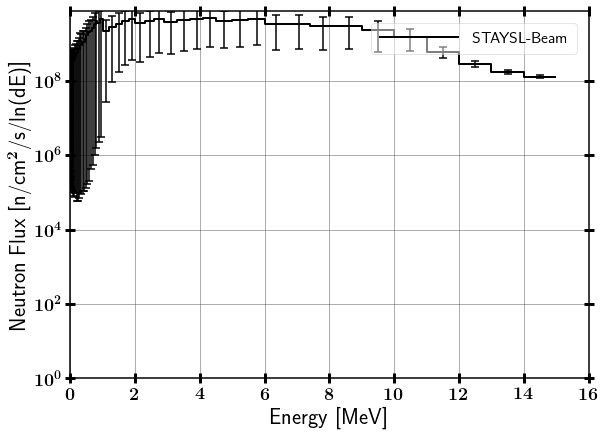

In [122]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration3/'
iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=True, chiConv=0.001))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())
iter = 2

iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(), iterSoln[iter]._df['adjLethargy'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjLethargy']).tolist(),
                             edgeLoc='low', name='STAYSL-Beam')

iterAdjHisto[iter].plot(xMin=1E-6, xMax=16, yMin=1, logX=False, logY=True, includeMarkers=False,
              xLabel='Energy [MeV]', yLabel='Neutron Flux [n/cm$^2$/s/ln(dE)]',
                        savePath=outpath+'PIN-Unfold_Itr{:1d}'.format(iter))